In [5]:
using Plots
pyplot()
using LinearAlgebra
using LaTeXStrings

## Numerical Integral of Spectral Accuracy

Recall the numerical methods of integral, we approximate $I = \int_{-1}^1 f(x) dx \approx \sum_{k = 0}^n \omega_k f(t_k)$, where the chosen of nodes $t_k$ and the weights $w_k$ do not rely on $f$ itself. Under the fixed integral scheme, one could give integral formulas of different orders. 

In fact, global polynomials can give an integral formula of a higher order.

Before designing the exact schemes, we should firstly define *the accuracy.* of an integral formula.

For an integral formula $ \int_{-1}^1 f(x) dx \approx \sum_{k = 0}^n \omega_k f(t_k) = Q_n(f)$, if for all the d-ordered polynomials $p$, $Q_n(p) =  \int_{-1}^1 p(x) dx$, we call the integral formula  **of $d$ ordered** accuracy.

###  Clenshaw Curtis Numerical Integration
 
Function  `ccint` will perfrom Clenshaw-Curtis Integration for the fnuction `f` on `n` $+ 1$ nodes on $[-1,1]$, returns the integral estimate and a vector of the nodes used. Note that `n` must be given!!

A classical stantil for numerical integral is from the interpolation stentil

$$
    f(x)\approx  p_n(x) = \sum_{k = 0}^{n} f(t_k) l_k(x).
$$
here we choose the nodes as Chebyshev ones, i.e. $t_k = - \cos (\frac{k\pi}{n}), k = 0,1, \cdots, n$. And the cardinal functions $l_k(x)$  are choosen as Lagrange ones.  

We compute the integral

$$
    \int_{-1}^{1}p_n(x) dx = \sum_{k = 0}^{n} f(t_k) \int_{-1}^{1} l_k(x) dx
$$
people have computed that $\int_{-1}^{1} l_k(x) dx := \omega_k$

$$
    \omega_k = \begin{cases} & \frac{1}{n^2 - 1} \qquad \qquad k = 0, k = n\\ & \frac{4}{n} \sum_{j = 0}^{n/2} \frac{ \cos (2 \pi jk/n)}{r_j(1 - 4j^2)} \qquad \text{otherwise}  \end{cases}, \text{ where } r_j = \begin{cases} &2 \qquad j = 0, j = n/2 \\ & 1 \qquad j = 1,2, \cdots n/2 - 1\end{cases}
$$



In [4]:
begin
    function ccint(f,n)
        @assert iseven(n) "Value of `n` must be an even integer."
        # Find Chebyshev extreme nodes.
        θ = [ i*π/n for i in 0:n ]
        x = -cos.(θ)
    
        # Compute the C-C weights.
        c = similar(θ)
        c[[1,n+1]] .= 1/(n^2-1)
        s = sum( cos.(2k*θ[2:n])/(4k^2-1) for k in 1:n/2-1 )
        v = @. 1 - 2s - cos(n*θ[2:n])/(n^2-1)
        c[2:n] = 2v/n
    
        # Evaluate integrand and integral.
        I = dot(c,f.(x))   # vector inner product
        return I,x
    end


end

ccint (generic function with 1 method)

For example! 

$$
    \int_{-1}^{1} \frac{1}{1 + 16 x^2} dx =  \frac{1}{2}\arctan (4) 
$$

We gonna draw the figure of its accuracy, to show that it is of spectrally convergence...

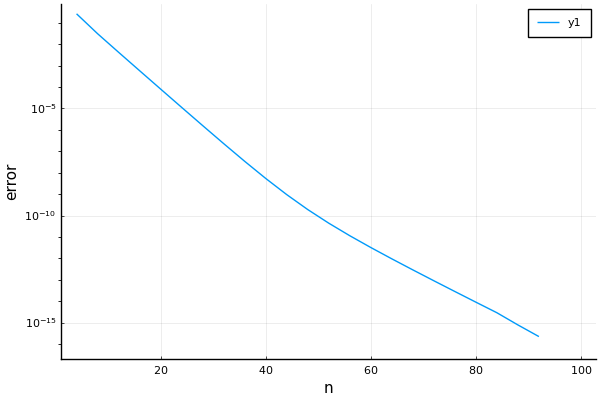

In [6]:
begin
    g = x -> 1/(1 + 16 * x ^ 2)
    exactg = atan(4)/2;
    m = 4:4:100
    error = zeros(size(m))
    for (k,n) in enumerate(m)
        ccintg = ccint(g,n)[1]
        error[k] = abs(ccintg - exactg)
    end
    error[error .<= 0] .= NaN
    plot(m, error,xaxis = ("n"),yaxis = (:log10, "error") )
end

###  Gauss–Legendre numerical integration

Function `glint` perform Gauss-Legendre integration for the function `f` on `n` nodes
 in $(-1,1)$. Returns the integral estimate and a vector of the nodes used.

`n` roots of Legendre Polynomials of degree $n$ are called Gauss points. 

Integral formula based on the intepolation on these points are called Gauss-Legendre numerical integration. 

In [7]:
begin
    """
    glint(f,n)
    Perform Gauss-Legendre integration for the function `f` on `n` nodes
    in (-1,1). Returns the integral estimate and a vector of the nodes used.
    """
    function glint(f,n)
        # Nodes and weights are found via a tridiagonal eigenvalue problem.
        β = @. 0.5/sqrt(1-(2*(1:n-1))^(-2))
        T = diagm(-1=>β,1=>β)
        λ,V = eigen(T)
        p = sortperm(λ)
        x = λ[p]               
        c = @. 2V[1,p]^2       
        # nodes
        # weights
        # Evaluate the integrand and compute the integral.
        I = dot(c,f.(x))      
        # vector inner product
        return I,x
    end
 end

glint

For the same example! 

$$
    \int_{-1}^{1} \frac{1}{1 + 16 x^2} dx =  \frac{1}{2}\arctan (4) 
$$

We gonna draw the figure of its accuracy, to show that it is of spectrally convergence...

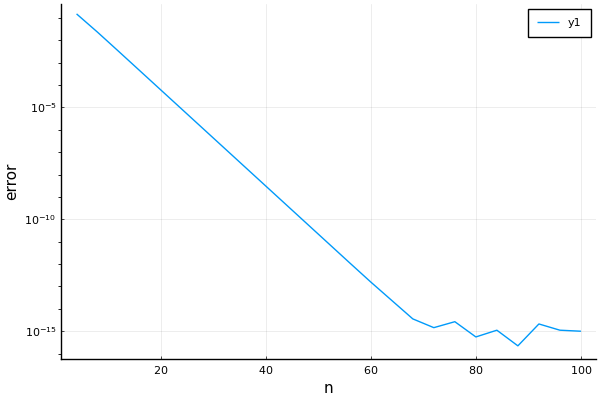

In [8]:
begin
    g = x -> 1/(1 + 16 * x ^ 2)
    exactg = atan(4)/2;
    m = 4:4:100
    error = zeros(size(m))
    for (k,n) in enumerate(m)
        glintg = glint(g,n)[1]
        error[k] = abs(glintg - exactg)
    end
    error[error .<= 0] .= NaN
    plot(m, error,xaxis = ("n"),yaxis = (:log10, "error") )
end

We analysis the two kinds of integral together, we can see from the former figure that the capability of convergence is similar between `ccint` and `glint`. They are all **spectrally-accurate**.

In fact, `ccint` has a degree of $n$, with $n + 1$ grids, and `glint` has a degree of $2n - 1$ with $n$ grids, so seemingly, `glint` converges fast twice as `ccint`. 

We compute the following integral, and compare them on a single figure. 

$$
    \int_{-1}^1 \frac{1}{1 + x^2}dx = 2\arctan (1)
$$

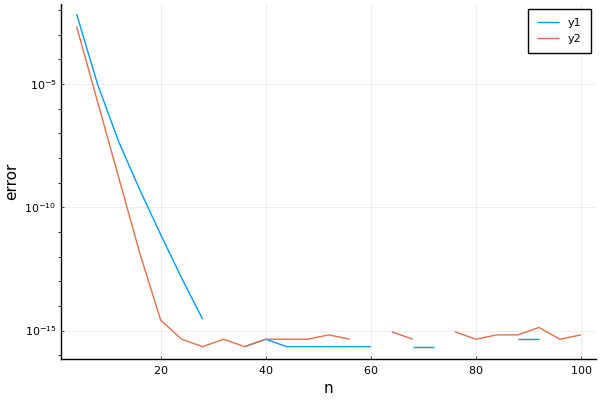

In [9]:
begin
    h =  x -> 1/(1 + x ^ 2)
    exactg = 2 * atan(1) ;
    m = 4:4:100
    error_cc = zeros(size(m))
    error_gl = zeros(size(m))
    for (k,n) in enumerate(m)
        ccintg = ccint(h,n)[1]
        glintg = glint(h,n)[1]
        error_cc[k] = abs(ccintg - exactg)
        error_gl[k] = abs(glintg - exactg)
    end
    error_cc[error_cc .<= 0] .= NaN
    error_gl[error_gl .<= 0] .= NaN
    plot(m, error_cc,xaxis = ("n"),yaxis = (:log10, "error") )
    plot!(m, error_gl,xaxis = ("n"),yaxis = (:log10, "error") )
end

### Chebyshev Differentiation Matrices

When we are doing a numerical integral task, what do we do first? --Interpolation!

Actually, numerical inteegral and differentiation are all based on the interpolation, or we can say that  **Interpolation determines the stentil**. 

Once the stentil is fixed, our attention should be paid to compute the differentiation matrices, that is matrices $D_N$, such that 

$$
    (Df(x_0), Df(x_1), \cdots, Df(x_n))^T = D_N (f(x_0), f(x_1), \cdots, f(x_n))^T .
$$



For each $N \geq1$ , let the rows and columns of the $( N+1 ) \times( N+1 )$ Chebyshev spectral differentiation matriz $D_{N}$ be indexed from $0$ to $N$ . The entries of this matriz are
$$
\left( D_{N} \right)_{0 0}=\frac{2 N^{2}+1} {6}, \qquad\left( D_{N} \right)_{N N}=-\frac{2 N^{2}+1} {6}, 
$$

$$
( D_{N} )_{j j}=\frac{-x_{j}} {2 ( 1-x_{j}^{2} )}, \qquad j=1, \ldots, N-1,
$$

$$
\left( D_{N} \right)_{i j}=\frac{c_{i}} {c_{j}} \frac{(-1 )^{i+j}} {( x_{i}-x_{j} )}, \qquad i \neq j, \quad i, j=1, \ldots, N-1,
$$
where
$$
c_{i}=\left\{\begin{array} {l l} {{2}} & {{i=0 \ o r \ N,}} \\ {{1}} & {{o t h e r w i s e.}} \\ \end{array} \right. 
$$


Now function `diffcheb` will compute Chebyshev differentiation matrices on `n`+1 points in the
 interval `xspan`. Returns a vector of nodes and the matrices for the
 first and second derivatives.

In [7]:
begin
"""
diffcheb(n,xspan)

Compute Chebyshev differentiation matrices on `n`+1 points in the
interval `xspan`. Returns a vector of nodes and the matrices for the
first and second derivatives.
"""
function diffcheb(n,xspan)
    x = [ -cos( k*π/n ) for k in 0:n ]    # nodes in [-1,1]
    
    # Off-diagonal entries.
    c = [2; ones(n-1); 2];    # endpoint factors
    dij = (i,j) -> (-1)^(i+j)*c[i+1]/(c[j+1]*(x[i+1]-x[j+1]))
    Dₓ = [ dij(i,j) for i in 0:n, j in 0:n ]

    # Diagonal entries.
    Dₓ[isinf.(Dₓ)] .= 0         # fix divisions by zero on diagonal
    s = sum(Dₓ,dims=2)
    Dₓ -= diagm(s[:,1])         # "negative sum trick"

    # Transplant to [a,b].
    a,b = xspan
    x = @. a + (b-a)*(x+1)/2
    Dₓ = 2*Dₓ/(b-a)             # chain rule

    # Second derivative.
    Dₓₓ = Dₓ^2
    return x,Dₓ,Dₓₓ
end
end

diffcheb

For example!  
$$
    f(x) = x + \exp(\sin(4x))
$$

Here, for comparing, we use another function `diffmat2`, which is a basic numerical method for order 2, you can see soon the greatness of spectrally accuracy!!

In [10]:
begin
    function diffmat2(n,xspan)
        a,b = xspan
        h = (b - a)/n 
        x = [ a + i * h for i in 0:n]
    
        Dxx = zeros(n + 1, n + 1)
        Dxx[1, 1:4] .= [2, -5, 4, -1]/(h^2)
        Dxx[n+1, (n-2):(n+1)] .= [-1, 4, -5, 2]/(h^2)
        for i in 2:n 
            Dxx[i, (i - 1):(i + 1)] .= [1, -2, 1]/(h^2)
        end
        
        Dx = zeros(n + 1, n + 1)
        Dx[1, 1:3] .= [-3,4,-1]/(2h)
        Dx[n+1, (n-1):(n+1)] .= [1,-4,3]/(2h)
        for i in 2:n 
            Dx[i, (i - 1):(i + 1)] .=[-1, 0, 1]/(2h)
        end
    return x, Dx, Dxx
    end
end

diffmat2 (generic function with 1 method)

In [ ]:
begin
    f = x -> x + exp(sin(4*x));
    dfdx = x -> 1 + 4*exp(sin(4*x)) * cos(4*x);
    d2fdx2 = x -> 4*exp(sin(4*x)) * (4*cos(4*x)^2-4*sin(4*x));

    m = @. round(Int,2^(4:.5:11) )
    err1 = zeros(size(m))
    err2 = zeros(size(m))
    for (k,n) in enumerate(m)
        t, lDₓ, lDₓₓ = diffmat2(n,[-1,1])
        y = f.(t)
        err1[k] = norm( dfdx.(t) - lDₓ*y, Inf )
        err2[k] = norm( d2fdx2.(t) - lDₓₓ*y, Inf )
    end
    plot(n, [err1 err2], m=:o, label=["f'" "f''"])
    plot!(n, 10*10*n.^(-2), l=(:dash,:gray), label="2nd order",
    xaxis=(:log10,"n"), yaxis=(:log10,"max error"),
    title="Convergence of finite differences");
end

UndefVarError: UndefVarError: `n` not defined

Now it is time for `diffcheb`!! We shall firstly output its matrices of 1 and 2 order(s) differentiation.

In [10]:
t, Dₓ, Dₓₓ = diffcheb(4, [-1,1])
Dₓ

5×5 Matrix{Float64}:
 -5.5        6.82843   -2.0           1.17157   -0.5
 -1.70711    0.707107   1.41421      -0.707107   0.292893
  0.5       -1.41421    1.11022e-16   1.41421   -0.5
 -0.292893   0.707107  -1.41421      -0.707107   1.70711
  0.5       -1.17157    2.0          -6.82843    5.5

In [11]:
Dₓₓ

5×5 Matrix{Float64}:
 17.0       -28.4853  18.0  -11.5147   5.0
  9.24264   -14.0      6.0   -2.0      0.757359
 -1.0         4.0     -6.0    4.0     -1.0
  0.757359   -2.0      6.0  -14.0      9.24264
  5.0       -11.5147  18.0  -28.4853  17.0

Now we show its convergence speed! 

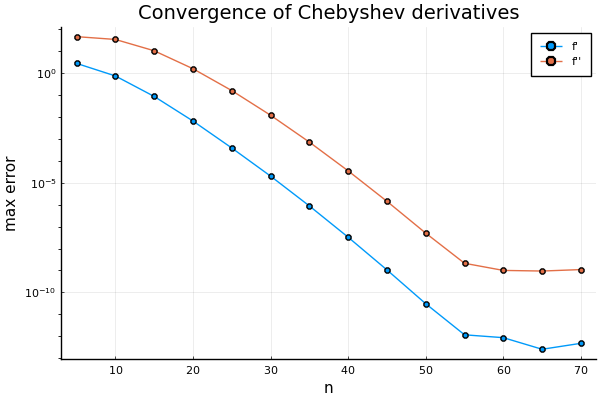

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [12]:
begin
    m = 5: 5: 70
    err1c = zeros(size(m))
    err2c = zeros(size(m))
    for (k,n) in enumerate(m)
        t, Dₓ, Dₓₓ = diffcheb(n,[-1,1])
        y = f.(t)
        err1c[k] = norm( dfdx.(t) - Dₓ*y, Inf )
        err2c[k] = norm( d2fdx2.(t) - Dₓₓ*y, Inf )
    end
    plot(m, [err1c err2c], m=:o, label = ["f'" "f''"],xaxis = ("n"), yaxis = (:log10 ,"max error"), title = "Convergence of Chebyshev derivatives");
end